<a href="https://colab.research.google.com/github/leowu4ever/PhD_Note/blob/master/ICBHI_dataset_conference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House keeping

In [372]:
from google.colab import drive
drive.mount('/content/drive')

import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import time

import librosa.display
import librosa.feature
import IPython.display as ipd
import datetime
from IPython.display import clear_output

!pip install pyhht
from pyhht.visualization import plot_imfs
import pyhht
import numpy as np
from pyhht import EMD

from scipy.signal import butter, lfilter, hilbert, chirp
from pyhht.utils import get_envelops, inst_freq
from IPython.core.interactiveshell import InteractiveShell
from numpy import mean, sqrt, square

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support

InteractiveShell.ast_node_interactivity = "all"

anno = pd.read_csv('/content/drive/My Drive/colab PhD/clinic_dataset/annotations_updated.csv', index_col=0)
sr = 4000
w = int(0.25 * sr)
folder_path = '/content/ICBHI_dataset/Respiratory_Sound_Database/audio_and_txt_files/'

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leowu4ever","key":"aa02345562758f8631f54b8edae33ad6"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vbookshelf/respiratory-sound-database
!mkdir ICBHI_dataset
!unzip respiratory-sound-database.zip -d ICBHI_dataset
!unzip ICBHI_dataset/Respiratory_Sound_Database.zip -d ICBHI_dataset/

100% 1.84G/1.84G [00:44<00:00, 47.0MB/s]
100% 1.84G/1.84G [00:44<00:00, 44.9MB/s]
Archive:  respiratory-sound-database.zip
  inflating: ICBHI_dataset/demographic_info.txt  
  inflating: ICBHI_dataset/Respiratory_Sound_Database.zip  
Archive:  ICBHI_dataset/Respiratory_Sound_Database.zip
   creating: ICBHI_dataset/Respiratory_Sound_Database/
  inflating: ICBHI_dataset/Respiratory_Sound_Database/.DS_Store  
   creating: ICBHI_dataset/__MACOSX/
   creating: ICBHI_dataset/__MACOSX/Respiratory_Sound_Database/
  inflating: ICBHI_dataset/__MACOSX/Respiratory_Sound_Database/._.DS_Store  
   creating: ICBHI_dataset/Respiratory_Sound_Database/audio_and_txt_files/
  inflating: ICBHI_dataset/Respiratory_Sound_Database/audio_and_txt_files/.DS_Store  
   creating: ICBHI_dataset/__MACOSX/Respiratory_Sound_Database/audio_and_txt_files/
  inflating: ICBHI_dataset/__MACOSX/Respiratory_Sound_Database/audio_and_txt_files/._.DS_Store  
  inflating: ICBHI_dataset/Respiratory_Sound_Database/audio_and_txt_fil

# Pre processing

In [0]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def normalise(clip):
    normalised_clip = librosa.util.normalize(clip)
    return normalised_clip

def hamming_window(clip):
    hamming_window = np.hamming(len(clip))
    hamming_windowed_clip = clip * hamming_window
    return hamming_windowed_clip


# Apps

In [0]:
#@title Plot comparison
a_index = 4729 #@param {type:"integer"}
b_index = 3455 #@param {type:"integer"}

a_wav_name = anno.loc[a_index, 'wav_name']
a_wav_start = anno.loc[a_index, 'start']
a_wav_end = anno.loc[a_index, 'end']
a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
a_wav_imfs = EMD(a_wav).decompose()

b_wav_name = anno.loc[b_index, 'wav_name']
b_wav_start = anno.loc[b_index, 'start']
b_wav_end = anno.loc[b_index, 'end']
b_wav = librosa.load(folder_path+b_wav_name, sr=sr)[0][int(b_wav_start*sr) : int(b_wav_end*sr)]
b_wav_imfs = EMD(b_wav).decompose()

fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20,10))

D = np.abs(librosa.stft(a_wav))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[0,0])

D = np.abs(librosa.stft(a_wav_imfs[0]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[1,0])

D = np.abs(librosa.stft(a_wav_imfs[1]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[2,0])

D = np.abs(librosa.stft(a_wav_imfs[2]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[3,0])

D = np.abs(librosa.stft(a_wav_imfs[3]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[4,0])

D = np.abs(librosa.stft(b_wav))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[0,1])

D = np.abs(librosa.stft(b_wav_imfs[0]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[1,1])

D = np.abs(librosa.stft(b_wav_imfs[1]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[2,1])

D = np.abs(librosa.stft(b_wav_imfs[2]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[3,1])

D = np.abs(librosa.stft(b_wav_imfs[3]))
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=4000, ax=axs[4,1])

axs[0,0].set_title(anno.loc[a_index, 'wav_name'] + ' ' + anno.loc[a_index, 'health status'] )
axs[0,1].set_title(anno.loc[b_index, 'wav_name'] + ' ' + anno.loc[b_index, 'health status'] )

In [0]:
#@title Look up index { run: "auto" }
health_status = "URTI" #@param ['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']
crackle = "1" #@param ["0", "1"]
wheeze = "0" #@param ["0", "1"]
chest_loc = "Al" #@param ['Al', 'Pr', 'Ar', 'Ll', 'Lr', 'Pl', 'Tc']
acquisition_mode = "sc" #@param ["sc", "mc"]
recording_equipment = "Meditron" #@param ['Meditron', 'LittC2SE', 'Litt3200', 'AKGC417L']
anno[
    (anno['health status'] == health_status) &
    (anno['crackles'] == int(crackle)) &
    (anno['wheezes'] == int(wheeze)) &
    (anno['chest loc'] == chest_loc) &
    (anno['acquisition mode'] == acquisition_mode) &
    (anno['recording equipment'] == recording_equipment)
]

In [0]:
#@title Play a cycle

a_index = 4734 #@param {type:"integer"}
a_wav_name = anno.loc[a_index, 'wav_name']
a_wav_start = anno.loc[a_index, 'start']
a_wav_end = anno.loc[a_index, 'end']
a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
anno.iloc[a_index:a_index+1,:]
ipd.Audio(data=a_wav, rate=sr)

,start,end,crackles,wheezes,wav_name,participant id,recording id,chest loc,acquisition mode,recording equipment,health status,Age,Sex,BMI (kg/m2),Weight (kg),Height (cm)),cycle class
4734,17.407,19.964,0.0,0.0,179_1b1_Al_sc_Meditron.wav,179,1b1,Al,sc,Meditron,Healthy,10.0,F,NaN,15.0,104.0,normal


Text(0.5, 1.0, 'original')

Text(0.5, 1.0, 'bandpass')

Text(0.5, 1.0, 'hamming window')

Text(0.5, 1.0, 'normalised')

Text(0.5, 1.0, 'imf_1')

Text(0.5, 1.0, 'imf_2')

Text(0.5, 1.0, 'imf_3')

Text(0.5, 1.0, 'imf_4')

Text(0.5, 1.0, 'normalised instantaneous frequency')

Text(0.5, 1.0, 'imf_1 instantaneous frequency')

Text(0.5, 1.0, 'upper instantaneous frequency')

Text(0.5, 1.0, 'lower instantaneous frequency')

Text(0.5, 1.0, 'original STFT')

Text(0.5, 1.0, 'imf_1 STFT')

Text(0.5, 1.0, 'imf_1 upper STFT')

Text(0.5, 1.0, 'imf_1 lower STFT')

Text(0.5, 0.98, 'cycle index(66)  104_1b1_Ll_sc_Litt3200.wav')

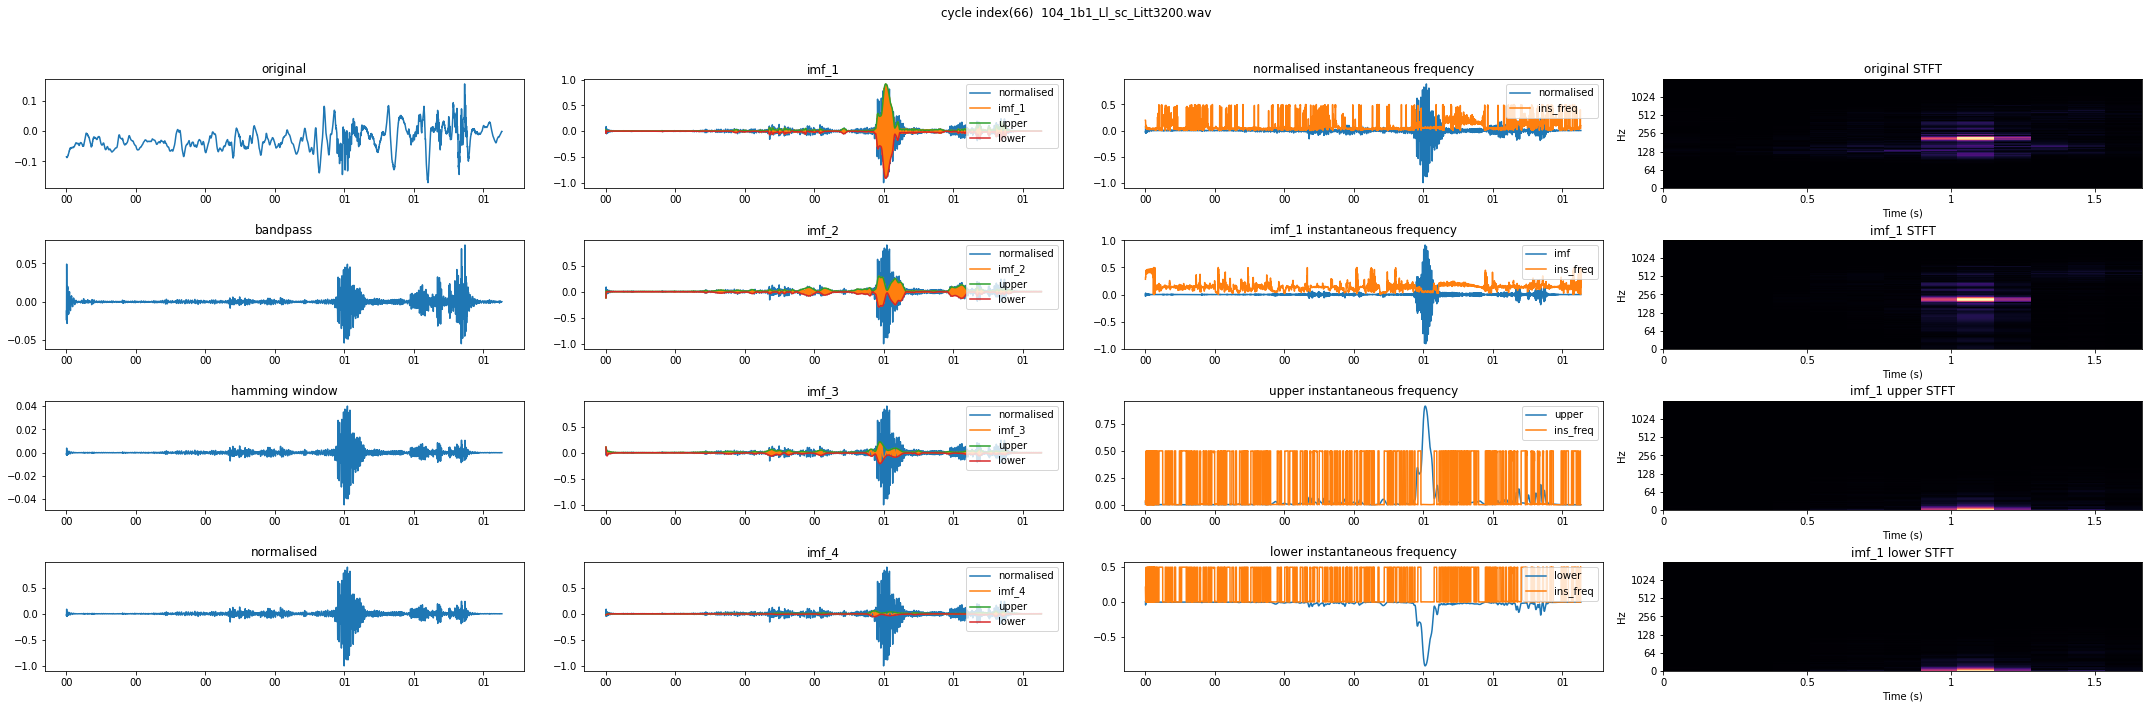

In [0]:
#@title Plot preprocessing

a_index = 66 #@param {type:"integer"}
imf_displayed = 1 #@param {type:"integer"}

a_wav_name = anno.loc[a_index, 'wav_name']
a_wav_start = anno.loc[a_index, 'start']
a_wav_end = anno.loc[a_index, 'end']
a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(30,10))

# preprocessing plot
axs[0,0].plot(a_wav)
axs[0,0].set_title('original')
formatter = matplotlib.ticker.FuncFormatter(lambda ms, x: time.strftime('%S', time.gmtime(ms//4000)))
axs[0,0].xaxis.set_major_formatter(formatter)

a_wav = butter_bandpass_filter(a_wav, 120, 1800, fs=sr, order=12)
axs[1,0].plot(a_wav)
axs[1,0].set_title('bandpass')
axs[1,0].xaxis.set_major_formatter(formatter)

a_wav = hamming_window(a_wav)
axs[2,0].plot(a_wav)
axs[2,0].set_title('hamming window')
axs[2,0].xaxis.set_major_formatter(formatter)

a_wav = normalise(a_wav)
axs[3,0].plot(a_wav)
axs[3,0].set_title('normalised')
axs[3,0].xaxis.set_major_formatter(formatter)

# EMD imfs plot
imfs = pyhht.emd.EMD(a_wav, n_imfs=4).decompose()
imf = imfs[0]
upper = get_envelops(imf)[0]
lower = get_envelops(imf)[1]
axs[0,1].plot(a_wav, label='normalised')
axs[0,1].plot(imf, label='imf_1')
axs[0,1].plot(upper, label='upper')
axs[0,1].plot(lower, label='lower')
axs[0,1].legend(loc='upper right')
axs[0,1].set_title('imf_1')
axs[0,1].xaxis.set_major_formatter(formatter)

imf = imfs[1]
upper = get_envelops(imf)[0]
lower = get_envelops(imf)[1]
axs[1,1].plot(a_wav, label='normalised')
axs[1,1].plot(imf, label='imf_2')
axs[1,1].plot(upper, label='upper')
axs[1,1].plot(lower, label='lower')
axs[1,1].legend(loc='upper right')
axs[1,1].set_title('imf_2')
axs[1,1].xaxis.set_major_formatter(formatter)

imf = imfs[2]
upper = get_envelops(imf)[0]
lower = get_envelops(imf)[1]
axs[2,1].plot(a_wav, label='normalised')
axs[2,1].plot(imf, label='imf_3')
axs[2,1].plot(upper, label='upper')
axs[2,1].plot(lower, label='lower')
axs[2,1].legend(loc='upper right')
axs[2,1].set_title('imf_3')
axs[2,1].xaxis.set_major_formatter(formatter)

imf = imfs[3]
upper = get_envelops(imf)[0]
lower = get_envelops(imf)[1]
axs[3,1].plot(a_wav, label='normalised')
axs[3,1].plot(imf, label='imf_4')
axs[3,1].plot(upper, label='upper')
axs[3,1].plot(lower, label='lower')
axs[3,1].legend(loc='upper right')
axs[3,1].set_title('imf_4')
axs[3,1].xaxis.set_major_formatter(formatter)

# hilbert transform

analytic_signal = hilbert(a_wav)
f, t = inst_freq(analytic_signal)
axs[0,2].plot(a_wav, label='normalised')
axs[0,2].plot(f, label='ins_freq')
axs[0,2].legend(loc='upper right')
axs[0,2].set_title('normalised instantaneous frequency')
axs[0,2].xaxis.set_major_formatter(formatter)

imf = imfs[imf_displayed-1]
upper = get_envelops(imf)[0]
lower = get_envelops(imf)[1]
analytic_signal = hilbert(imf)
f, t = inst_freq(analytic_signal)
axs[1,2].plot(imf, label='imf')
axs[1,2].plot(f, label='ins_freq')
axs[1,2].legend(loc='upper right')
axs[1,2].set_title('imf_' + str(imf_displayed) +' instantaneous frequency')
axs[1,2].xaxis.set_major_formatter(formatter)

analytic_signal = hilbert(upper)
f, t = inst_freq(analytic_signal)
axs[2,2].plot(upper, label='upper')
axs[2,2].plot(f, label='ins_freq')
axs[2,2].legend(loc='upper right')
axs[2,2].set_title('upper instantaneous frequency')
axs[2,2].xaxis.set_major_formatter(formatter)

analytic_signal = hilbert(lower)
f, t = inst_freq(analytic_signal)
axs[3,2].plot(lower, label='lower')
axs[3,2].plot(f, label='ins_freq')
axs[3,2].legend(loc='upper right')
axs[3,2].set_title('lower instantaneous frequency')
axs[3,2].xaxis.set_major_formatter(formatter)

# stft
D = np.abs(librosa.stft(a_wav))
librosa.display.specshow(D, y_axis='log', x_axis='s', sr=sr, ax=axs[0,3])
axs[0,3].set_title('original STFT')

D = np.abs(librosa.stft(imf))
librosa.display.specshow(D, y_axis='log', x_axis='s', sr=sr, ax=axs[1,3])
axs[1,3].set_title('imf_' + str(imf_displayed) + ' STFT')

D = np.abs(librosa.stft(upper))
librosa.display.specshow(D, y_axis='log', x_axis='s', sr=sr, ax=axs[2,3])
axs[2,3].set_title('imf_' + str(imf_displayed) + ' upper STFT')

D = np.abs(librosa.stft(lower))
librosa.display.specshow(D, y_axis='log', x_axis='s', sr=sr, ax=axs[3,3])
axs[3,3].set_title('imf_' + str(imf_displayed) + ' lower STFT')

plt.suptitle('cycle index(' + str(a_index) + ')  ' + anno.loc[a_index, 'wav_name'])
fig.tight_layout()
fig.subplots_adjust(top=0.88)


# Create classes

In [0]:
anno[(anno['crackles']==1) & (anno['wheezes']==0)]['health status'].value_counts()

COPD              1779
Pneumonia           21
URTI                21
Healthy             16
Bronchiolitis       15
Bronchiectasis      12
Name: health status, dtype: int64

In [0]:
cra_cyc_df = anno[(anno['crackles']==1) & (anno['wheezes']==0)]

In [0]:
for index, row in cra_cyc_df.iterrows():
  if(cra_cyc_df.loc[index, 'health status'] == 'Healthy'):
    cra_cyc_df.loc[index, 'healthy/unhealthy']='Healthy'
  if(cra_cyc_df.loc[index, 'health status'] != 'Healthy'):
    cra_cyc_df.loc[index, 'healthy/unhealthy']='Unhealthy'

  if(cra_cyc_df.loc[index, 'health status'] == 'Healthy'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Healthy'
  if(cra_cyc_df.loc[index, 'health status'] == 'COPD'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Chronic'
  if(cra_cyc_df.loc[index, 'health status'] == 'Bronchiectasis'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Chronic'
  if(cra_cyc_df.loc[index, 'health status'] == 'URTI'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Non-chronic'
  if(cra_cyc_df.loc[index, 'health status'] == 'Pneumonia'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Non-chronic'
  if(cra_cyc_df.loc[index, 'health status'] == 'Bronchiolitis'):
    cra_cyc_df.loc[index, 'chronic/non-chronic']='Non-chronic'

In [0]:
cra_cyc_df.to_csv('/content/drive/My Drive/colab PhD/clinic_dataset/' + 'crackle_cycles_with_class.csv')

# Feature extraction

In [0]:
def create_features(range="0025", df=df):
  counter = 0
  total = str(df.shape[0])
  for index, row in df.iterrows():
    
    counter = counter + 1
    print (str(counter) + '/' + total)

    a_wav_name = row['wav_name']
    a_wav_start = row['start']
    a_wav_end = row['end']

    if(range == '0100'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]

    if(range == '0075'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
      a_wav = a_wav[0 : int(0.75*len(a_wav))]

    if(range == '0050'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
      a_wav = a_wav[0 : int(0.5*len(a_wav))]

    if(range == '5075'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
      a_wav = a_wav[int(0.5*len(a_wav)) : int(0.75*len(a_wav))]

    if(range == '2550'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
      a_wav = a_wav[int(0.25*len(a_wav)) : int(0.5*len(a_wav))]

    if(range == '0025'):
      a_wav = librosa.load(folder_path+a_wav_name, sr=sr)[0][int(a_wav_start*sr) : int(a_wav_end*sr)]
      a_wav = a_wav[0 : int(0.25*len(a_wav))]

    a_wav = butter_bandpass_filter(a_wav, 120, 1800, fs=sr, order=12)
    a_wav = hamming_window(a_wav)
    a_wav = normalise(a_wav)

    imfs = pyhht.emd.EMD(a_wav, n_imfs=3).decompose()
    imfs_count = len(imfs)
    if(imfs_count >= 3):
      for i in np.arange(3):
        imf = imfs[0]    
        # rms
        rms = sqrt(mean(square(imf)))
        df.loc[index, 'imf' + str(i+1) + '_rms_' + range] = rms
        # max amp
        upper = get_envelops(imf)[0]
        max_amp = max(upper)
        df.loc[index, 'imf' + str(i+1)  + '_max_amp_' + range] = max_amp
        # mean if
        f, t = inst_freq(hilbert(imf))
        mean_if = mean(f)
        df.loc[index, 'imf' + str(i+1)  + '_mean_if_' + range] = mean_if
        
        # spectral centroid
        spc_centroid = librosa.feature.spectral_centroid(imf, sr=sr)
        std = np.std(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_std' + range] = std
        var = np.var(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_var' + range] = var
        minn = np.min(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_min' + range] = minn
        maxx = np.max(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_max' + range] = maxx
        med = np.median(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_median' + range] = med
        meann = np.mean(spc_centroid)
        df.loc[index, 'imf' + str(i+1)  + '_centroid_mean' + range] = meann
     
        # spectral bandwidth
        spc_bandwidth = librosa.feature.spectral_bandwidth(imf, sr=sr)
        std = np.std(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_std' + range] = std
        var = np.var(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_var' + range] = var
        minn = np.min(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_min' + range] = minn
        maxx = np.max(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_max' + range] = maxx
        med = np.median(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_median' + range] = med
        meann = np.mean(spc_bandwidth)
        df.loc[index, 'imf' + str(i+1)  + '_bandwidth_mean' + range] = meann

        # spectral flatness
        spc_flatness = librosa.feature.spectral_flatness(imf)
        std = np.std(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_std' + range] = std
        var = np.var(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_var' + range] = var
        minn = np.min(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_min' + range] = minn
        maxx = np.max(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_max' + range] = maxx
        med = np.median(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_median' + range] = med
        meann = np.mean(spc_flatness)
        df.loc[index, 'imf' + str(i+1)  + '_flatness_mean' + range] = meann

        # spectral rolloff
        spc_rolloff = librosa.feature.spectral_rolloff(imf, sr=sr)
        std = np.std(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_std' + range] = std
        var = np.var(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_var' + range] = var
        minn = np.min(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_min' + range] = minn
        maxx = np.max(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_max' + range] = maxx
        med = np.median(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_median' + range] = med
        meann = np.mean(spc_rolloff)
        df.loc[index, 'imf' + str(i+1)  + '_rolloff_mean' + range] = meann        
        
        # mfcc
        mfcc = librosa.feature.mfcc(imf, n_mfcc=13, sr=sr)
        mfcc_mean = np.mean(mfcc, axis=1)
        for j in np.arange(len(mfcc)):
          df.loc[index, 'imf' + str(i+1)  + 'mfcc' + str(j) + range] = mfcc_mean[j]        

    else:
      df.drop(index, inplace=True)
      print("drop {}".format(str(index)))

In [0]:
create_features(range="0100", df=df)

In [0]:
df.sort_values('health status', inplace=True)
df_copd = df[df['health status'] == 'COPD'].drop_duplicates('participant id')
df_non_copd = df[df['health status'] != 'COPD']
df = df_non_copd.append(df_copd)

In [0]:
df.to_csv('/content/drive/My Drive/colab PhD/clinic_dataset/' + 'crackle_cycles_with_class_features_less_copd_spectrals.csv')

# Classification

In [0]:
df = pd.read_csv('/content/drive/My Drive/colab PhD/clinic_dataset/crackle_cycles_with_class_features_less_copd.csv', index_col=0)

In [0]:
df_0025 = df.columns[19:28]
df_2550 = df.columns[28:37]
df_0050 = df.columns[37:46]
df_0100 = df.columns[46:56]

In [0]:
def classify(features, label):
  feature_cols = features

  label_col = label
  X = df[feature_cols]
  y = df[label_col]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

  rfc = RandomForestClassifier(n_estimators=500, random_state=0)  
  rfc.fit(X_train, y_train.values.ravel())  
  y_pred = rfc.predict(X_test)

  accuracy = np.asarray(accuracy_score(y_test,y_pred))
  _, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='micro')
  scores = np.asarray(precision_recall_fscore_support(y_test,y_pred, average='micro'))
  results = np.append(accuracy, scores)

  print("\nacc pre rec f1 spe")
  print(str(round(results[0],2)) + ',' +
      str(round(results[1],2)) + ',' +
      str(round(results[2],2)) + ',' +
      str(round(results[3],2)) + ',' +
      str(round(specificity)))

  confusion = confusion_matrix(y_test, y_pred)
  print("\nConfusion matrix: \n{}".format(confusion))

  report = classification_report(y_test, y_pred)
  print("\nClassification report: \n{}".format(report))

In [0]:
features = df_0025.append(df_2550).append(df_0100)
labels = ['health status']ß
for label in labels:
  classify(features, label)